#### Importing Required libraries

In [26]:
# Python libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing tensorflow libraries
import tensorflow as tf
from tensorflow import keras

# Graph Visualization
import pydot
import graphviz

import warnings
warnings.filterwarnings("ignore")

## Part 1: Model Architecture

### Data Preprocessing and Augmentation

In [2]:
import tensorflow as tf

def calculate_mean_std(dataset):
    pixel_sum, pixel_square_sum, num_pixels = 0.0, 0.0, 0
    for image, _ in dataset:
        pixel_sum += tf.reduce_sum(image)
        pixel_square_sum += tf.reduce_sum(tf.square(image))
        num_pixels += tf.size(image)

    mean = pixel_sum / tf.cast(num_pixels, tf.float32)
    std_dev = tf.sqrt(
        pixel_square_sum / tf.cast(num_pixels, tf.float32) - tf.square(mean)
    )
    return mean, std_dev

def normalize_image(image, mean, std_dev):
    # Subtract mean and divide by standard deviation
    return (image - mean) / std_dev

# Function to normalize image and label pairs
def normalize_image_dataset(image, label):
    image = normalize_image(image, mean, std_dev)
    return image, label

# Function to apply horizontal reflection
def horizontal_reflection(image, label):
    image = tf.image.flip_left_right(image)
    return image, label

# Function to adjust brightness
def adjusting_brightness(image, label):
    image = tf.image.adjust_brightness(image, 0.2)
    return image, label

def DataAugmentation(dataset):
    # Applying Mean Normalization
    dataset = dataset.map(normalize_image_dataset, num_parallel_calls=tf.data.AUTOTUNE)

    # Applying Horizontal flip
    dataset = dataset.map(horizontal_reflection, num_parallel_calls=tf.data.AUTOTUNE)

    # Applying brightness adjustment
    dataset = dataset.map(adjusting_brightness, num_parallel_calls=tf.data.AUTOTUNE)

    return dataset




### Implementing ReLU

In [3]:
import tensorflow as tf

# ReLU activation function
relu = tf.keras.activations.relu

# Example tensor from a numpy array
x = tf.constant([1.0, -1.0, -0.5, 0.32])

# Applying ReLU
relu_x = relu(x)

#Output = [1.0, 0.0, 0.0, 0.32]



### Conv2D (Sliding Window Approach)

In [4]:
import numpy as np

class Conv2D:
    def __init__(self, filters, kernel_size, stride=1, padding='valid'):
        '''
        Initializes the Conv2D layer.
        
        Parameters:
        - filters (int): Number of filters to apply.
        - kernel_size (tuple): Size of the kernel (height, width).
        - stride (int): Step size for moving the kernel over the input.
        - padding (str): 'valid' (no padding) or 'same' (padding to keep spatial dimensions).
        '''
        self.filters = filters
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.kernels = None  # To hold the kernels once initialized

    def initialize_kernels(self, input_channels):
        '''
        Initializes the kernels (filters) for each input channel.
        
        Parameters:
        - input_channels (int): Number of channels in the input image.
        
        This method randomly initializes the kernels with a normal distribution.
        Each kernel has a shape of (filters, kernel_height, kernel_width, input_channels).
        '''
        kernel_height, kernel_width = self.kernel_size
        # Randomly initialize kernels for each filter and input channel
        self.kernels = np.random.randn(self.filters, kernel_height, kernel_width, input_channels)

    def apply_padding(self, image, pad_h, pad_w):
        '''
        Pads the input image with zeros if necessary.
        
        Parameters:
        - image (np.array): The input image.
        - pad_h (int): Height of padding.
        - pad_w (int): Width of padding.
        
        Returns:
        - np.array: The padded image.
        '''
        return np.pad(image, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant', constant_values=0)

    def forward(self, image):
        '''
        Performs the convolution operation on the input image.
        
        Parameters:
        - image (np.array): Input image with shape (height, width, channels).
        
        Returns:
        - np.array: Output of the convolution operation with shape (output_height, output_width, filters).
        '''
        # Initialize the kernels if not done already
        if self.kernels is None:
            self.initialize_kernels(input_channels=image.shape[2])

        # Image dimensions and kernel dimensions
        image_height, image_width, image_channels = image.shape
        kernel_height, kernel_width, _ = self.kernels.shape[1:]
        
        # Calculate padding if needed
        if self.padding == 'same':
            pad_h = (kernel_height - 1) // 2
            pad_w = (kernel_width - 1) // 2
            image = self.apply_padding(image, pad_h, pad_w)
        elif self.padding == 'valid':
            pad_h, pad_w = 0, 0

        # Calculate output dimensions
        output_height = (image.shape[0] - kernel_height) // self.stride + 1
        output_width = (image.shape[1] - kernel_width) // self.stride + 1
        
        # Initialize the output array to store feature maps for each filter
        result = np.zeros((output_height, output_width, self.filters))
        
        # Perform convolution
        for f in range(self.filters):
            # Select the kernel for the current filter
            kernel = self.kernels[f]
            for y in range(output_height):
                for x in range(output_width):
                    # Extract the region of interest for the current location and all channels
                    region = image[
                        y * self.stride : y * self.stride + kernel_height,
                        x * self.stride : x * self.stride + kernel_width,
                        :
                    ]
                    # Apply the filter to the region and sum across channels
                    result[y, x, f] = np.sum(region * kernel)
        
        return result

# Example usage
# Simulated RGB image with dimensions (227, 227, 3)
image = np.random.randn(227, 227,3)

# Instantiate the Conv2D layer with 96 filters, an 11x11 kernel size, stride of 4, and 'same' padding
conv_layer = Conv2D(filters=96, kernel_size=(11, 11), stride=4, padding='valid')

# Apply the convolution layer to the image
output = conv_layer.forward(image)

print("Image shape:\n", image.shape)
print("Output Shape of convolution:\n", output.shape)


Image shape:
 (227, 227, 3)
Output Shape of convolution:
 (55, 55, 96)


### MaxPooling2D (Sliding Window Approach)


In [5]:
import numpy as np

class MaxPooling2D:
    def __init__(self, pool_size=(2, 2), stride=None, padding='valid'):
        """
        Initializes the MaxPooling2D layer.
        
        Parameters:
        - pool_size (tuple): Size of the pooling window (height, width).
        - stride (int or tuple): Step size for moving the pooling window.
        - padding (str): 'valid' (no padding) or 'same' (zero padding).
        """
        self.pool_size = pool_size
        self.stride = stride if stride is not None else pool_size  # Default to pool_size if stride is None
        self.padding = padding

    def apply_padding(self, image, pad_h, pad_w):
        """
        Pads the input image with zeros if necessary.
        
        Parameters:
        - image (np.array): The input image.
        - pad_h (int): Padding height.
        - pad_w (int): Padding width.
        
        Returns:
        - np.array: Padded image.
        """
        return np.pad(image, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant', constant_values=0)

    def forward(self, image):
        """
        Performs the max pooling operation.
        
        Parameters:
        - image (np.array): Input image with shape (height, width, channels).
        
        Returns:
        - np.array: The pooled image.
        """
        # Image dimensions
        image_height, image_width, channels = image.shape
        pool_height, pool_width = self.pool_size

        # Padding if necessary
        if self.padding == 'same':
            pad_h = (pool_height - 1) // 2
            pad_w = (pool_width - 1) // 2
            image = self.apply_padding(image, pad_h, pad_w)
        elif self.padding == 'valid':
            pad_h, pad_w = 0, 0

        # Calculate output dimensions
        output_height = (image.shape[0] - pool_height) // self.stride[0] + 1
        output_width = (image.shape[1] - pool_width) // self.stride[1] + 1
        
        # Initialize the output array
        pooled_output = np.zeros((output_height, output_width, channels))

        # Perform pooling operation
        for h in range(output_height):
            for w in range(output_width):
                for c in range(channels):
                    # Extract the region of interest (ROI) for the current filter position
                    region = image[
                        h * self.stride[0]: h * self.stride[0] + pool_height,
                        w * self.stride[1]: w * self.stride[1] + pool_width,
                        c
                    ]
                    # Apply max pooling to the region
                    pooled_output[h, w, c] = np.max(region)

        return pooled_output

# Example usage
# Simulated image with batch size of 1, height=6, width=6, and 1 channel
image = np.random.randn(55, 55, 96)

# Instantiate the MaxPooling2D layer with pool_size=(2, 2), stride=(2, 2), and 'valid' padding
#max_pool = MaxPooling2D(pool_size=(2, 2), stride=(2, 2), padding='valid')
max_pool= MaxPooling2D(pool_size=(3,3), stride=(2,2), padding='valid')


# Apply the max pooling operation to the image
output = max_pool.forward(image)
print("Input Shape:\n",image.shape)
print("Output Shape of MaxPooling2D:\n", output.shape)


Input Shape:
 (55, 55, 96)
Output Shape of MaxPooling2D:
 (27, 27, 96)


### Fully Connected Layers

In [6]:
class Dense:
    def __init__(self, in_features, out_features):
        """
        Initializes the Dense (fully connected) layer.
        
        Parameters:
        - input_size (int): Number of input features.
        - output_size (int): Number of output features.
        """
        self.input_size = in_features
        self.output_size = out_features
        self.weights = None
        self.biases = None
        self.initialize_params()

    def initialize_params(self):
        """
        Initializes weights and biases with random values.
        
        Weights are initialized using a normal distribution.
        Biases are initialized to zeros.
        """
        self.weights = np.random.randn(self.input_size, self.output_size) * np.sqrt(2. / self.input_size)
        self.biases = np.zeros((1, self.output_size))

    def forward(self, input_data):
        """
        Performs the forward pass of the Dense layer.
        
        Parameters:
        - input_data (np.array): Input data with shape (batch_size, input_size).
        
        Returns:
        - np.array: Output of the dense layer with shape (batch_size, output_size).
        """
        return np.dot(input_data, self.weights) + self.biases



### Local Response Normalization

In [7]:
import numpy as np

class custom_LocalResponseNormalization:
    def __init__(self, depth_radius=5, bias=1.0, alpha=1e-4, beta=0.75):
        """
        Initializes the LocalResponseNormalization layer.

        Parameters:
        - depth_radius (int): Number of neighboring channels for normalization.
        - bias (float): Added to the normalization term to avoid division by zero.
        - alpha (float): Scaling parameter.
        - beta (float): Exponent for normalization.
        """
        self.depth_radius = depth_radius
        self.bias = bias
        self.alpha = alpha
        self.beta = beta

    def forward(self, X):
        """
        Applies local response normalization to the input data.

        Parameters:
        - X (np.array): Input data with shape (height, width, channels).

        Returns:
        - np.array: The normalized data.
        """
        H, W, C = X.shape  # height, width, channels
        squared_input = np.square(X)
        output = np.zeros_like(X)

        for h in range(H):  # Iterate over height
            for w in range(W):  # Iterate over width
                for c in range(C):  # Iterate over channels
                    # Define the start and end of the depth radius range
                    start = max(0, c - self.depth_radius // 2)
                    end = min(C, c + self.depth_radius // 2 + 1)

                    # Sum the square of inputs within the local region
                    local_sum = np.sum(squared_input[h, w, start:end], axis=0)
                    
                    # Apply LRN formula
                    scale = self.bias + (self.alpha * local_sum)
                    output[h, w, c] = X[h, w, c] / (scale ** self.beta)

        return output




<h2>Sample Execution</h2> 

<p style="font-family: Arial, sans-serif; font-size: 16px; line-height: 1.6; padding: 10px 0; text-align: justify;">This execution demonstrates the forward pass of an AlexNet-inspired model, <b>implemented using custom-defined convolutional and pooling layers (sliding window approach)</b> instead of built-in deep learning frameworks. The model processes a 227×227×3 input image, extracting hierarchical features through multiple convolutional and pooling operations. These features are then passed through fully connected layers, ultimately producing a probability distribution over 1,000 classes. This approach showcases a fundamental understanding of CNN architectures by implementing key components from scratch.</p>

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow as tf

# Apply ReLU activation in TensorFlow


class AlexNetModel:
    def __init__(self, input_shape=(224,224,3)):
        self.input_shape = input_shape
        #self.model = self.build_model()
        
    def forward(self,X):

        #First Conv Layer
        conv1_layer = Conv2D(filters=96, kernel_size=(11, 11), stride=4, padding='valid')
        X=conv1_layer.forward(X)
        X=tf.nn.relu(X) 
        lrn_custom = custom_LocalResponseNormalization()
        X = lrn_custom.forward(X)


        #First Max Pooling Layer
        max_pool= MaxPooling2D(pool_size=(3,3), stride=(2,2), padding='valid')
        X=max_pool.forward(X)


        #Second Conv Layer
        conv2_layer = Conv2D(filters=256, kernel_size=(5, 5), stride=1, padding='same')
        X=conv2_layer.forward(X)
        X=tf.nn.relu(X) 
        lrn_custom = custom_LocalResponseNormalization()
        X = lrn_custom.forward(X)


        #Second Max Pooling Layer
        max_pool = MaxPooling2D(pool_size=(3, 3), stride=(2, 2), padding='valid')
        X=max_pool.forward(X)


        #Third Conv Layer
        conv3_layer = Conv2D(filters=384, kernel_size=(3, 3), stride=1, padding='same')
        X=conv3_layer.forward(X)
        X=tf.nn.relu(X) 


        #Fourth Conv Layer
        conv4_layer = Conv2D(filters=384, kernel_size=(3, 3), stride=1, padding='same')
        X=conv4_layer.forward(X)
        X=tf.nn.relu(X) 

        #Fifth Conv Layer
        conv5_layer = Conv2D(filters=256, kernel_size=(3, 3), stride=1, padding='same')
        X=conv5_layer.forward(X)
        X=tf.nn.relu(X) 

        #third Max Pooling Layer
        max_pool = MaxPooling2D(pool_size=(3, 3), stride=(2, 2), padding='valid')
        X=max_pool.forward(X)

        X=X.flatten()  #flattening to make it compatible for fully connected layers


        #fully connected layer1
        X_fc1=Dense(in_features=9216,out_features=4096)        
        X=X_fc1.forward(X)
        X=tf.nn.relu(X)
        X = tf.nn.dropout(X, 0.5) 
        

        #fully connected layer2
        X_fc2=Dense(in_features=4096,out_features=4096)
        X=X_fc2.forward(X)
        X=tf.nn.relu(X)
        X = tf.nn.dropout(X, 0.5) 



        #output (softmax) layer
        X_fc3=Dense(in_features=4096,out_features=1000)
        y=X_fc3.forward(X)

        y=tf.nn.softmax(y)

        return y

    def summary(self):
        return self.model.summary()

# Instantiate the AlexNet model class and print the summary
X=np.random.randn(227,227,3)
alexnet = AlexNetModel()
y=alexnet.forward(X)
y.shape
#alexnet.summary()



TensorShape([1, 1000])

## Model Training

### Defining the Model - AlexNet

In [9]:
def compile_and_train_alexnet(model, initial_lr=0.01, decay=0.0005, patience=10, min_lr=1e-6):
    """
    Compiles and trains an AlexNet model using SGD optimizer with a ReduceLROnPlateau learning rate scheduler.

    Parameters:
    - model: The uncompiled AlexNet model.
    - initial_lr (float): Starting learning rate for the optimizer.
    - decay (float): Weight decay parameter for regularization.
    - patience (int): Number of epochs with no improvement after which learning rate will be reduced.
    - min_lr (float): Minimum learning rate for the scheduler.

    Returns:
    - model: The compiled model ready for training.
    """

    # Define the SGD optimizer with the specified initial learning rate and weight decay
    sgd_optimizer = tf.keras.optimizers.SGD(
        learning_rate=initial_lr,
        weight_decay=decay,
        nesterov=False  # Nesterov momentum is not used
    )

    # Compile the model with the defined optimizer, categorical crossentropy loss, and accuracy metric
    model.compile(
        optimizer=sgd_optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Set up a ReduceLROnPlateau callback to reduce the learning rate by a factor of 10 when validation loss plateaus
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",  # Monitor the validation loss to determine when to adjust learning rate
        factor=0.1,          # Reduce learning rate by a factor of 10
        patience=patience,   # Number of epochs with no improvement before reducing the learning rate
        min_lr=min_lr        # Set a floor for the learning rate
    )

    # Display model architecture
    model.summary()

    return model, lr_scheduler


### Training the Model with Callbacks for Checkpointing, Early Stopping, and Learning Rate Adjustment

In [10]:
def train_model_with_callbacks(model, train_data, valid_data, checkpoint_dir, lr_scheduler, patience=10, epochs=50):
    """
    Train the model with callbacks for checkpointing, early stopping, and learning rate reduction.
    
    Args:
        model: The model to be trained.
        train_data: The training dataset.
        valid_data: The validation dataset.
        checkpoint_dir: Directory where the model checkpoints will be saved.
        lr_scheduler: Learning rate scheduler callback.
        patience: Patience for early stopping, default is 10.
        epochs: Number of epochs to train the model, default is 50.
    
    Returns:
        model_fit: The result of model training (fit history).
    """
    
    # Define the checkpoint path with epoch in the filename
    checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:04d}.weights.h5")  # creates the checkpoint at epoch level

    # Callbacks for Checkpointing
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, verbose=1, save_weights_only=True
    )

    # Callbacks for EarlyStopping
    es = tf.keras.callbacks.EarlyStopping(patience=patience, monitor="loss")

    # Train the model
    model_fit = model.fit(
        train_data,
        validation_data=valid_data,
        epochs=epochs,
        callbacks=[es, cp_callback, lr_scheduler]
    )
    
    return model_fit


## Part 3: A Real World Example

<h3> Splitting the dataset into train and Validation </h3>

- seed = 123
- validation_split_ratio = 0.1

In [11]:
img_height = 224
img_width = 224
batch_size = 2  # '2' because we have a small set of samples

In [12]:
df_train = tf.keras.preprocessing.image_dataset_from_directory(
    "Imagenet_mini/train",
    labels="inferred",  # Automatically labels are picked based on the sub_directories name
    label_mode="categorical",  # labels are encoded as a categorical vector(for categorical loss )
    # class_names = ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray',
    #               'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch','house_finch', 'junco', 'indigo_bunting',
    #                'robin'], # This is the explicit list of class names (must match names of subdirectories)
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(
        img_height,
        img_width,
    ),  # Size to resize images to after they are read from disk,
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset="training",
)

Found 513 files belonging to 16 classes.
Using 462 files for training.


In [13]:
df_valid = tf.keras.preprocessing.image_dataset_from_directory(
    "Imagenet_mini/train",
    labels="inferred",  # Automatically labels are picked based on the sub_directories name
    label_mode="categorical",  # labels are encoded as a categorical vector(for categorical loss )
    # class_names = ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray',
    #               'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch','house_finch', 'junco', 'indigo_bunting',
    #                'robin'], # This is the explicit list of class names (must match names of subdirectories)
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(
        img_height,
        img_width,
    ),  # Size to resize images to after they are read from disk,
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset="validation",
)

Found 513 files belonging to 16 classes.
Using 51 files for validation.


<h2> Sample Visualization of Training dataset after Resizing Images </h2>

2024-11-17 19:21:43.036463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


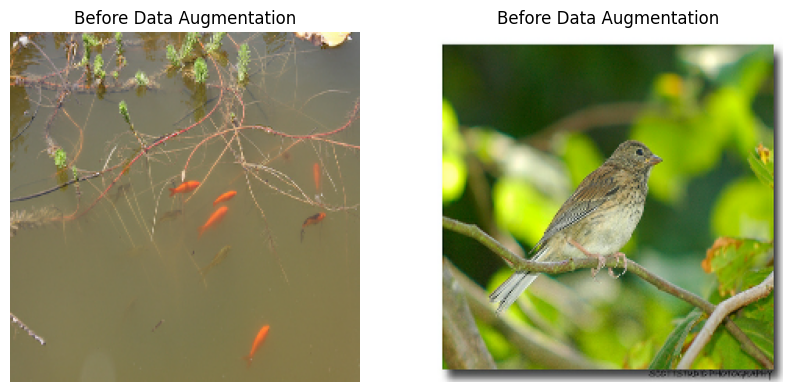

In [23]:
plt.figure(figsize=(10, 10))
for images, labels in df_train.take(1):
    for i in range(2):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Before Data Augmentation")  # Add this line
        plt.axis("off")
plt.show()

<a id="Data_Augumentation_data" style="color: black; text-decoration: none;"><h2> Data Augmentation(Post loading the Images)</h2></a>

### 1. Mean Normalization
- First, we have to calculate dataset mean and standard deviation
- Normalizing each image using calculated mean 

In [15]:
def calculate_mean_std(dataset):
    pixel_sum, pixel_square_sum, num_pixels = 0.0, 0.0, 0
    for image, _ in dataset:
        pixel_sum += tf.reduce_sum(image)
        pixel_square_sum += tf.reduce_sum(tf.square(image))
        num_pixels += tf.size(image)

    mean = pixel_sum / tf.cast(num_pixels, tf.float32)
    std_dev = tf.sqrt(
        pixel_square_sum / tf.cast(num_pixels, tf.float32) - tf.square(mean)
    )
    return mean, std_dev

In [16]:
def normalize_image(image, mean, std_dev):
    # Subtract mean and divide by standard deviation
    return image - mean

In [17]:
# Calculate mean and standard deviation from the training dataset
mean, std_dev = calculate_mean_std(df_train)


# Function to normalize image
def normalize_image_dataset(image, label):
    image = normalize_image(image, mean, std_dev)
    return image, label

2024-11-17 19:20:31.038529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 2.Horizontal reflections

In [18]:
def horizontal_reflection(image, label):
    image = tf.image.flip_left_right(image)
    return image, label

### 3.Altering the Intensities

In [19]:
def adjusting_brightness(image, label):
    image = tf.image.adjust_brightness(image, 0.2)
    return image, label

In [20]:
def DataAugmentation(dataset):

    # Applying Mean Normalization
    dataset = dataset.map(normalize_image_dataset, num_parallel_calls=tf.data.AUTOTUNE)

    # Applying Horizontal flip
    dataset = dataset.map(horizontal_reflection, num_parallel_calls=tf.data.AUTOTUNE)

    # Applying Adjusting Brightness
    # dataset = dataset.map(adjusting_brightness, num_parallel_calls = tf.data.AUTOTUNE)

    return dataset

In [21]:
normalized_train_df = DataAugmentation(df_train)
# Optimizing Purpose
normalized_train_df = normalized_train_df.prefetch(tf.data.AUTOTUNE)


normalized_valid_df = DataAugmentation(df_valid)
# Optimizing Purpose
normalized_valid_df = normalized_valid_df.prefetch(tf.data.AUTOTUNE)

<h2> Sample Visualization of Training dataset post full data Augmentation </h2>

2024-11-17 19:21:49.782143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


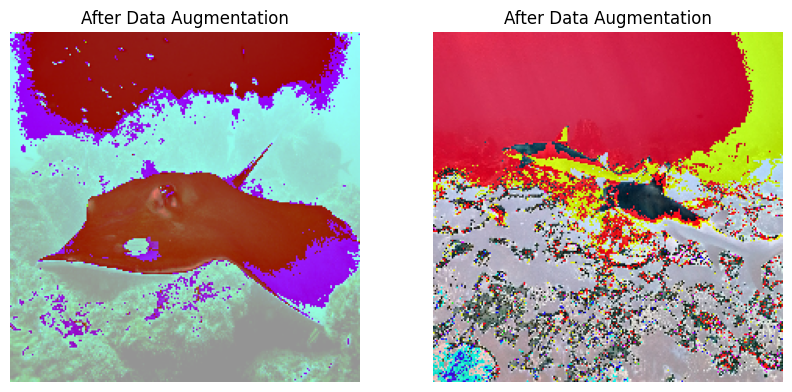

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in normalized_train_df.take(1):
    for i in range(2):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("After Data Augmentation")
        plt.axis("off")


<a id="Training_System" style="color: black; text-decoration: none;"><h2>AlexNet Model</h2></a>

In [27]:
model = tf.keras.models.Sequential(
    [
        # 1st conv
        tf.keras.layers.Conv2D(
            96, (11, 11), strides=(4, 4), activation="relu", input_shape=(224, 224, 3)
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(3, strides=(2, 2)),  # Overlap Pooling layer
        # 2nd conv
        tf.keras.layers.Conv2D(
            256, (5, 5), strides=(1, 1), activation="relu", padding="same"
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(3, strides=(2, 2)),  # Overlap Pooling layer
        # 3rd conv
        tf.keras.layers.Conv2D(
            384, (3, 3), strides=(1, 1), activation="relu", padding="same"
        ),
        tf.keras.layers.BatchNormalization(),
        # 4th conv
        tf.keras.layers.Conv2D(
            384, (3, 3), strides=(1, 1), activation="relu", padding="same"
        ),
        tf.keras.layers.BatchNormalization(),
        # 5th Conv
        tf.keras.layers.Conv2D(
            256, (3, 3), strides=(1, 1), activation="relu", padding="same"
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(3, strides=(2, 2)),  # Overlap Pooling layer
        # To Flatten layer
        tf.keras.layers.Flatten(),
        # To FC layer 1
        tf.keras.layers.Dense(4096, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        # To FC layer 2
        tf.keras.layers.Dense(4096, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation="softmax"),
    ]
)



<a id="Training_the_model" style="color: black; text-decoration: none;"><h2>Model Setup and Training Configuration</h2></a>

<p style="font-family: Arial, sans-serif; font-size: 16px; line-height: 1.6; padding: 10px 0;text-align: justify;">As per the paper, we are configuring a Alexnet model, by defining the SGD optimizer with an initial learning rate of 0.01, supplemented by a weight decay of 0.0005 for regularization to prevent overfitting. The model is compiled using categorical cross-entropy as the loss function, suitable for multi-class problems, and accuracy as the performance metric. To improve convergence, we implement a ReduceLROnPlateau callback that dynamically reduces the learning rate by a factor of 0.1 if validation loss does not improve for 10 consecutive epochs, ensuring that training remains effective without excessively low learning rates. Finally, the model.summary() function provides a detailed architectural overview, listing each layer’s type, output shape, and parameter count, which is valuable for documentation and model assessment. This setup supports adaptive learning, regularization, and consistent monitoring, forming a robust foundation for model training and evaluation.</p>

In [28]:
def compile_and_train_alexnet(model, initial_lr=0.01, decay=0.0005, patience=10, min_lr=1e-6):
    """
    Compiles and trains an AlexNet model using SGD optimizer with a ReduceLROnPlateau learning rate scheduler.

    Parameters:
    - model: The uncompiled AlexNet model.
    - initial_lr (float): Starting learning rate for the optimizer.
    - decay (float): Weight decay parameter for regularization.
    - patience (int): Number of epochs with no improvement after which learning rate will be reduced.
    - min_lr (float): Minimum learning rate for the scheduler.

    Returns:
    - model: The compiled model ready for training.
    """

    # Define the SGD optimizer with the specified initial learning rate and weight decay
    sgd_optimizer = tf.keras.optimizers.SGD(
        learning_rate=initial_lr,
        weight_decay=decay,
        nesterov=False  # Nesterov momentum is not used
    )

    # Compile the model with the defined optimizer, categorical crossentropy loss, and accuracy metric
    model.compile(
        optimizer=sgd_optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Set up a ReduceLROnPlateau callback to reduce the learning rate by a factor of 10 when validation loss plateaus
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",  # Monitor the validation loss to determine when to adjust learning rate
        factor=0.1,          # Reduce learning rate by a factor of 10
        patience=patience,   # Number of epochs with no improvement before reducing the learning rate
        min_lr=min_lr        # Set a floor for the learning rate
    )

    # Display model architecture
    model.summary()

    return model, lr_scheduler

In [29]:
model, lr_scheduler = compile_and_train_alexnet(model)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 54, 54, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │        65,552 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,818,064 (178.60 MB)

 Trainable params: 46,815,312 (178.59 MB)

 Non-trainable params: 2,752 (10.75 KB)

### Model Checkpointing, Early Stopping, and Training Configuration

In [30]:
def train_model_with_callbacks(model, train_data, valid_data, checkpoint_dir, lr_scheduler, patience=10, epochs=50):
    """
    Train the model with callbacks for checkpointing, early stopping, and learning rate reduction.
    
    Args:
        model: The model to be trained.
        train_data: The training dataset.
        valid_data: The validation dataset.
        checkpoint_dir: Directory where the model checkpoints will be saved.
        lr_scheduler: Learning rate scheduler callback.
        patience: Patience for early stopping, default is 10.
        epochs: Number of epochs to train the model, default is 50.
    
    Returns:
        model_fit: The result of model training (fit history).
    """
    
    # Define the checkpoint path with epoch in the filename
    checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:04d}.weights.h5")  # creates the checkpoint at epoch level

    # Callbacks for Checkpointing
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, verbose=1, save_weights_only=True
    )

    # Callbacks for EarlyStopping
    es = tf.keras.callbacks.EarlyStopping(patience=patience, monitor="loss")

    # Train the model
    model_fit = model.fit(
        train_data,
        validation_data=valid_data,
        epochs=epochs,
        callbacks=[es, cp_callback, lr_scheduler]
    )
    
    return model_fit

In [31]:
model_fit_1 = train_model_with_callbacks(model= model,
                           train_data= normalized_train_df,
                           valid_data= normalized_valid_df,
                           checkpoint_dir="model_training_excAdjBrig_incWeiDec",
                           lr_scheduler= lr_scheduler,
                           patience=10, 
                           epochs=50)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.0680 - loss: 30.1693
Epoch 1: saving model to model_training_excAdjBrig_incWeiDec/cp-0001.weights.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.0680 - loss: 30.1090 - val_accuracy: 0.1176 - val_loss: 4.3790 - learning_rate: 0.0100
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.0844 - loss: 5.3418
Epoch 2: saving model to model_training_excAdjBrig_incWeiDec/cp-0002.weights.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.0844 - loss: 5.3394 - val_accuracy: 0.0588 - val_loss: 3.5982 - learning_rate: 0.0100
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0961 - loss: 3.8792
Epoch 3: saving model to model_training_excAdjBrig_incWeiDec/cp-0003.weights.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.0960 - loss: 3.8785 - val_accuracy: 0.0784 - val_loss: 3.3251 - learning_rate: 0.0100
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.1


<a id="Evaluation" style="color: black; text-decoration: none;"><h2>Evaluation</h2></a>



In [32]:
# Evaluate the Training model
loss, acc = model.evaluate(normalized_train_df, verbose=2)
print("Trained model, accuracy: {:5.2f}%".format(100 * acc))

231/231 - 4s - 19ms/step - accuracy: 0.8182 - loss: 0.7818
Trained model, accuracy: 81.82%


In [33]:
# Evaluate the Validation model
loss, acc = model.evaluate(normalized_valid_df, verbose=2)
print("Trained model, accuracy: {:5.2f}%".format(100 * acc))

26/26 - 1s - 20ms/step - accuracy: 0.2353 - loss: 2.6801
Trained model, accuracy: 23.53%
